## This is Indian Bird Species Image Classification.

Dataset is from Kaggle. link: https://www.kaggle.com/datasets/arjunbasandrai/25-indian-bird-species-with-226k-images

Instead of creating new CNN from start, we Will be using Microsoft's ResNet50V2 to fine-tune it according to our dataset.

In [1]:
import tensorflow as tf
tf.__version__ 

'2.9.0'

## Import The Libraries 

In [58]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor

In [5]:
import sklearn

In [6]:
# Import helper functions - https://gist.github.com/priteshkeleven/5756d60c56b3ac37c86cef348e76452f
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

## Getting the dataset

In [3]:
# Paths
train_dir = 'training_set'
test_dir = 'testing_set'

In [4]:
IMAGE_SIZE = [224, 224, 3]

In [5]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                                batch_size=16)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                               shuffle=False,
                                                               batch_size=16)

Found 16974 files belonging to 25 classes.


2023-03-28 16:23:34.936867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 16:23:34.982309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 16:23:34.982372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 16:23:34.982973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

Found 5647 files belonging to 25 classes.


In [7]:
# Creat checkpoint callback
checkpoint_path = "25_classes_birds_data_model_checkpoint/checkpoints.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)

### Lets implement data augmentation layer to avoid overfitting

In [51]:
# Create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomHeight(0.3),
    layers.RandomWidth(0.3),
    layers.RandomZoom(0.3),
    layers.Rescaling(1/255.)
], name="data_augmentation")

### Visualizing Augmentation layers

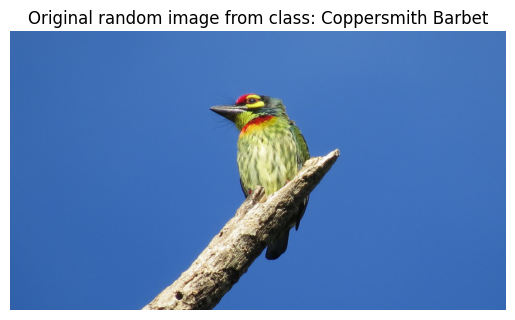

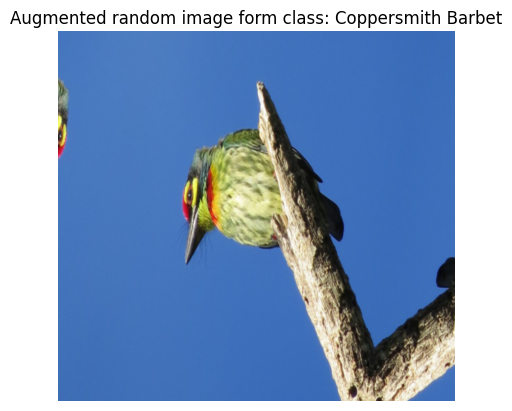

In [52]:
# View a random image and comapare it to augmentaed image
target_class = random.choice(train_data.class_names)
target_dir = "training_set/" + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path  = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Plot augmented image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img)
plt.title(f"Augmented random image form class: {target_class}")
plt.axis(False);

##  Creating Base Model

### Using ResNet50V2 as a base pre-trained model

In [53]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)

base_model.trainable = False

base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                      

### Structuring base_model

In [12]:
# Setup model architecture with trainable top layres
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # Augment images during training
x = base_model(x, training=False) # put base model in inference mode to set weights frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

In [13]:
# Compile the model
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_avg_pool_layer (Glob  (None, 2048)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 25)                51225     
                                                                 
Total params: 23,616,025
Trainable params: 51,225
Non-trainab

### Training base model with our dataset

In [ ]:
# Fit the model
base_model_history = model.fit(train_data,
                              epochs=5,
                              validation_data=test_data,
                              validation_steps=int(0.15*len(test_data)),
                              callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning", experiment_name="base_model")])                               

### Load already saved model

In [16]:
model = tf.keras.models.load_model('bird_clf_resnet50v2_base_model.h5')

In [31]:
# Evaluate on whole test dataset
base_model_results = model.evaluate(test_data)
base_model_results

239/353 [===================>..........] - ETA: 4s - loss: 0.6411 - accuracy: 0.8324

2023-03-25 22:07:56.981868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/353 [====================>.........] - ETA: 4s - loss: 0.6377 - accuracy: 0.8315

2023-03-25 22:07:57.382174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-25 22:07:57.382757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


317/353 [=========================>....] - ETA: 1s - loss: 0.5826 - accuracy: 0.8452

2023-03-25 22:07:59.938045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


353/353 [==============================] - 15s 41ms/step - loss: 0.5703 - accuracy: 0.8505


[0.5703216195106506, 0.8505401015281677]

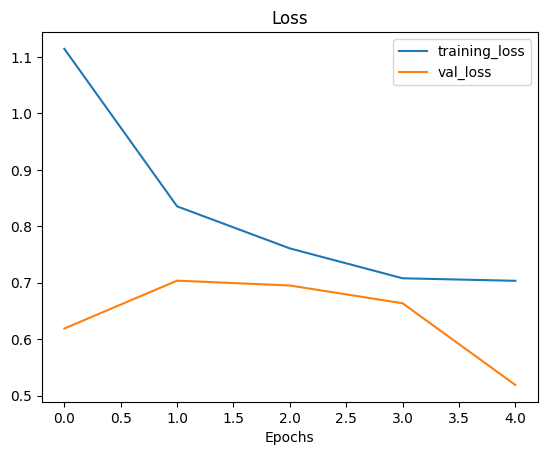

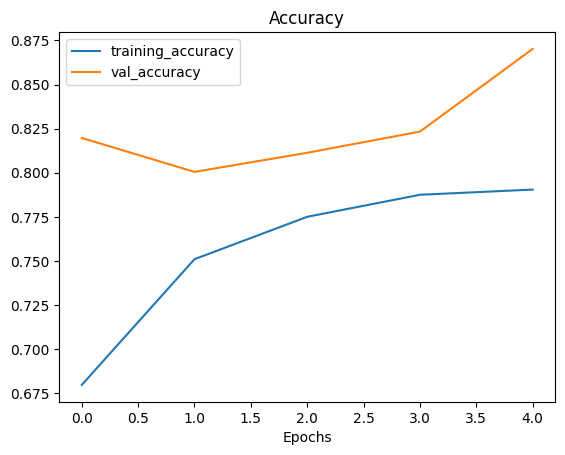

In [32]:
plot_loss_curves(base_model_history)

In [34]:
model.save('bird_clf_resnet50v2_base_model.h5')

## Fine Tuning - Last 5 Layers

In [35]:
# unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [36]:
for i, layer in enumerate(base_model.layers[-10:]):
    print(i, layer.name, layer.trainable)
    

0 conv5_block3_1_bn False
1 conv5_block3_1_relu False
2 conv5_block3_2_pad False
3 conv5_block3_2_conv False
4 conv5_block3_2_bn False
5 conv5_block3_2_relu True
6 conv5_block3_3_conv True
7 conv5_block3_out True
8 post_bn True
9 post_relu True


In [37]:
# Recompiling model with lower learning_rate
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=["accuracy"])

In [38]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_avg_pool_layer (Glob  (None, 2048)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 25)                51225     
                                                                 
Total params: 23,616,025
Trainable params: 1,105,945
Non-tr

In [ ]:
# Fit the model again
initial_epochs = 5
history_fine_tuned_5_layers_base_model = model.fit(train_data,
                                                 epochs=initial_epochs + 5,
                                                 validation_data=test_data,
                                                 validation_steps=int(0.15 * len(test_data)),
                                                 initial_epoch=base_model_history.epoch[-1],
                                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                       experiment_name="history_fine_tuned_5_layers_base_model")])


In [40]:
# Evaluate on whole test dataset
fine_tune_5_layers_results = model.evaluate(test_data)
fine_tune_5_layers_results

238/353 [===================>..........] - ETA: 4s - loss: 0.5325 - accuracy: 0.8564

2023-03-25 22:42:12.235521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/353 [====================>.........] - ETA: 4s - loss: 0.5237 - accuracy: 0.8580

2023-03-25 22:42:12.702094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-25 22:42:12.703044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


318/353 [==========================>...] - ETA: 1s - loss: 0.4868 - accuracy: 0.8667

2023-03-25 22:42:15.542373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


353/353 [==============================] - 15s 42ms/step - loss: 0.4837 - accuracy: 0.8697


[0.4836820960044861, 0.8696653246879578]

### Load fine-tuned model

In [118]:
model = tf.keras.models.load_model('bird_clf_resnet50v2_fine_tuned_5_layers.h5')

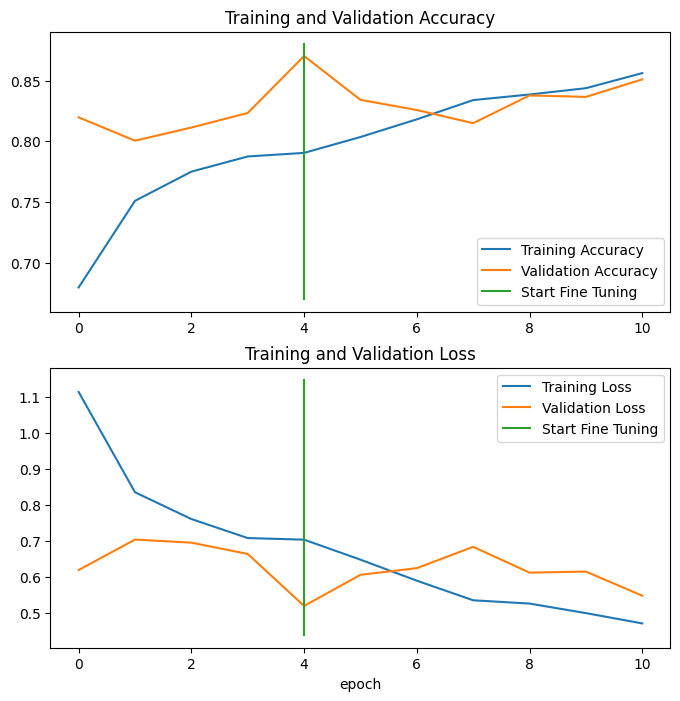

In [41]:
compare_historys(original_history=base_model_history,
                new_history=history_fine_tuned_5_layers_base_model,
                initial_epochs=5)

In [6]:
model = tf.keras.models.load_model("bird_clf_resnet50v2_fine_tuned_5_layers.h5")

## Save Model

In [7]:
# Save it as a h5 file
model.save('bird_clf_resnet50v2_fine_tuned_5_layers.h5')

## Implementing Reinforcement Learning for Fine-tuning ResNet50V2 - NOT WORKING

We are not able to run reinforcement learning since DQN agent requires only 1 output from our fine-tuned model while it gives list of 25 which is not supported by DQN agent. 

Ref: https://github.com/anubhavpatrick/Medical-Image-Classification-using-Deep-Reinforcement-Learning/blob/main/train_model.py

In [122]:
INPUT_SHAPE = (224, 224, 3)

In [123]:
class ClassifyProcessor(Processor):
    def process_observation(self, observation):
        img = observation.reshape(INPUT_SHAPE)
        processed_observation = np.array(img)
        return processed_observation

    def process_state_batch(self, batch):
        batch = batch.reshape((-1,) + INPUT_SHAPE)
        processed_batch = batch.astype('float32') / 1.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [124]:
memory = SequentialMemory(limit=100000, window_length=1)
processor = ClassifyProcessor()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=100000)

In [126]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_avg_pool_layer (Glob  (None, 2048)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 25)                51225     
                                                                 
Total params: 23,616,025
Trainable params: 1,105,945
Non-tr

In [127]:
dqn = DQNAgent(model=model, nb_actions=len(test_data.class_names), policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=0.5, target_model_update=10000,
               train_interval=4, delta_clip=1.)
dqn.compile(Adam(learning_rate=.00025), metrics=['mae'])

dqn.fit(env, nb_steps=training_steps, log_interval=60000)

TypeError: Keras symbolic inputs/outputs do not implement `__len__`. You may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model. This error will also get raised if you try asserting a symbolic input/output directly.

### Implementing AgentCritic methods for Image Classification. - NOT WORKING - Own Work

Model is not accpting input shape of image. It's getting converted in between layers.

In [76]:
import cv2

def preprocess_image(image_path):
    try:
        # Load the image from the specified path
        image = cv2.imread(image_path)

        # Check if the image is None or empty
        if image is None or image.size == 0:
            raise ValueError(f"Failed to read image from {image_path}")

        # Resize the image to a fixed size
        image = cv2.resize(image, (224, 224))

        # Convert the image to floating point format
        image = image.astype('float32')

        # Normalize the image by dividing by 255
        image /= 255

        return image
    except Exception as e:
        print(image_path)
        print(f"Error processing image {image_path}: {str(e)}")
        return None


In [88]:
# Define a custom gym environment
class CustomEnv(gym.Env):
    def __init__(self):
        self.train_dir = "training_set"
        self.test_dir = "testing_set"
        self.training_mode = True
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(224, 224, 3),
            dtype='uint8'
        )
        self.action_space = gym.spaces.Box(
            low=-1,
            high=1,
            shape=(1,),
            dtype='float32'
        )
        # Initialize ResNet50V2 model
        self.model = model
        # Unfreeze last 5 layers for fine-tuning
        for layer in self.model.layers[-5:]:
            layer.trainable = True
        # Add top layers for action prediction
        x = Flatten()(self.model.output)
        x = Dense(512, activation='relu')(x)
        self.output_layer = Dense(self.action_space.shape[0])(x)
        self.model = Model(inputs=self.model.input, outputs=self.output_layer)
        # Define optimizer
        self.optimizer = Adam(learning_rate=0.001)
        # Define loss function
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        self.current_observation = None
        self.current_step = 0
        self.max_steps = 1000
        self.reward_range = (-float('inf'), float('inf'))
        
    def _get_observation(self):
        if self.training_mode:
            # Get the path to a random image in the train directory
            class_dir = np.random.choice(os.listdir(self.train_dir))
            image_file = os.path.join(self.train_dir, class_dir, np.random.choice(os.listdir(os.path.join(train_dir, class_dir))))
        else:
            # Get the path to the next image in the test directory
            class_dir = np.random.choice(os.listdir(self.test_dir))
            image_file = os.path.join(self.test_dir, class_dir, np.random.choice(os.listdir(os.path.join(test_dir, class_dir))))

        # Preprocess the image
        image = preprocess_image(image_file)

        # Get the current joint angles and velocities

        # Combine the image and joint states into an observation
        observation = {"image": image}

        return observation

    def reset(self):
        self.current_step = 0
        
        # Generate a new observation as the initial state
        observation = self._get_observation()
        self.current_observation = observation
        
        # Return the initial observation
        return observation

    def step(self, action):
        # Take action in environment and return new observation, reward, and done flag
        self.current_step += 1
        new_state = self.current_observation + action
        features = self.model.predict(new_state[None])[0]
        reward = self._compute_reward(new_state, self.current_observation, action)
        done = (self.current_step >= self.max_steps)
        self.current_observation = new_state
        return features.reshape(-1), reward, done, {}
    
    def _compute_reward(self, new_state, previous_state, action):
        # Compute the reward based on the new and previous states and the action taken
        reward = np.sum(np.abs(new_state - previous_state))

        # Return the reward
        return reward

    def render(self, mode='human'):
        # Render environment
        pass

In [107]:
# Define RL agent
class Agent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.policy_network = self._build_policy_network()

    def _build_policy_network(self):
        inputs = tf.keras.layers.Input(shape=self.observation_space.shape)
        # x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
        resnet = model
        for layer in resnet.layers[:-5]:
            layer.trainable = False
        x = resnet(inputs)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        outputs = tf.keras.layers.Dense(self.action_space.shape[0], activation='tanh')(x)
        policy_network = tf.keras.models.Model(inputs=inputs, outputs=outputs)
        return policy_network
    
    def choose_action(self, observation):
        # Use the policy network to generate an action
        action = self.policy_network.predict([state])[0]
        
        # Clip the action value to be within the valid range
        action = np.clip(action, self.action_space.low, self.action_space.high)

        # Return the action
        return action

    def train(self, iterations):
        for i in range(iterations):
            observation = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(observation)
                new_observation, reward, done, _ = self.env.step(action)
                # Update policy network using RL algorithm
                pass

In [108]:
import gym
import numpy as np

# Create an instance of the CustomEnv class
env = CustomEnv()

# Create an instance of the Agent class
agent = Agent(env)

# Define the training loop
num_episodes = 1000
max_steps_per_episode = 1000
batch_size = 16
discount_factor = 0.99
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for episode in range(num_episodes):
    # Reset the environment for the start of the episode
    state = env.reset()
    episode_reward = 0
    episode_states = []
    episode_actions = []
    episode_rewards = []

    for step in range(max_steps_per_episode):
        # Choose an action based on the current state
        action = agent.choose_action(state)

        # Take a step in the environment based on the chosen action
        new_state, reward, done, info = env.step(action)
        
        # Compute the reward for the current step
        previous_state = state if step == 0 else episode_states[-1]
        step_reward = agent._compute_reward(new_state, previous_state, action)

        # Add the state, action, and reward to the episode history
        episode_states.append(state)
        episode_actions.append(action)
        episode_rewards.append(step_reward)
        episode_reward += step_reward

        # Update the current state
        state = new_state

        # If the episode is over, break out of the loop
        if done:
            break

    # Compute the discounted rewards for each step in the episode
    episode_discounted_rewards = np.zeros_like(episode_rewards)
    cumulative_reward = 0
    for i in reversed(range(len(episode_rewards))):
        cumulative_reward = episode_rewards[i] + discount_factor * cumulative_reward
        episode_discounted_rewards[i] = cumulative_reward

    # Normalize the discounted rewards
    episode_discounted_rewards -= np.mean(episode_discounted_rewards)
    episode_discounted_rewards /= np.std(episode_discounted_rewards)

    # Train the policy network using the episode history
    num_batches = len(episode_states) // batch_size
    for batch in range(num_batches):
        batch_start = batch * batch_size
        batch_end = (batch + 1) * batch_size

        # Get the batch of states, actions, and discounted rewards
        batch_states = np.array(episode_states[batch_start:batch_end])
        batch_actions = np.array(episode_actions[batch_start:batch_end])
        batch_discounted_rewards = np.array(episode_discounted_rewards[batch_start:batch_end])

        # Compute the loss and gradients
        with tf.GradientTape() as tape:
            logits = agent.policy_network(batch_states)
            loss = -tf.reduce_mean(batch_discounted_rewards * tf.math.log(logits + 1e-10) + (1 - batch_discounted_rewards) * tf.math.log(1 - logits + 1e-10))
        gradients = tape.gradient(loss, agent.policy_network.trainable_variables)

        # Apply the gradients to the optimizer
        optimizer.apply_gradients(zip(gradients, agent.policy_network.trainable_variables))

    # Print the episode reward every 10 episodes
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1}, Reward: {episode_reward}")


ValueError: in user code:

    File "/home/priteshk/miniconda3/envs/hf/lib/python3.10/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/home/priteshk/miniconda3/envs/hf/lib/python3.10/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/priteshk/miniconda3/envs/hf/lib/python3.10/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/home/priteshk/miniconda3/envs/hf/lib/python3.10/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/home/priteshk/miniconda3/envs/hf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/priteshk/miniconda3/envs/hf/lib/python3.10/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_57" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 224, 3)


## Predict on Test Model

In [9]:
preds_probs = model.predict(test_data)

2023-03-28 16:24:20.320572: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700


  5/353 [..............................] - ETA: 13s 

2023-03-28 16:24:24.101015: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


239/353 [===================>..........] - ETA: 4s

2023-03-28 16:24:33.165492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/353 [====================>.........] - ETA: 3s

2023-03-28 16:24:33.585175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-28 16:24:33.585680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


318/353 [==========================>...] - ETA: 1s

2023-03-28 16:24:36.221128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


353/353 [==============================] - 23s 41ms/step


In [10]:
preds_probs

array([[5.57500064e-01, 1.49156470e-02, 3.95028167e-07, ...,
        4.03020772e-09, 1.92685297e-06, 7.63295027e-09],
       [8.00372899e-01, 6.03676625e-02, 9.12816540e-05, ...,
        4.56398884e-05, 1.27164649e-05, 1.05896497e-05],
       [9.99792397e-01, 1.87173882e-05, 1.92202324e-10, ...,
        1.31564887e-12, 1.08445420e-04, 1.29400293e-11],
       ...,
       [3.80474596e-13, 2.90768583e-08, 4.39055185e-07, ...,
        3.23493628e-11, 5.69656819e-08, 9.99963522e-01],
       [1.64871852e-10, 4.19621711e-06, 4.79005530e-06, ...,
        1.58595073e-03, 1.12237494e-07, 9.04017329e-01],
       [3.26277561e-10, 1.61820171e-05, 5.30638536e-05, ...,
        1.70158764e-05, 3.15923759e-10, 9.24969256e-01]], dtype=float32)

In [11]:
prediction = np.argmax(preds_probs, axis = 1)
prediction

array([ 0,  0,  0, ..., 24, 24, 24])

## Evaluate on the Test Set

In [12]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=0)
print("Loss on test set: {}".format(test_loss))
print("Accuracy on test set: {:.4f}%".format(test_accuracy*100))

2023-03-28 16:24:57.769452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-28 16:24:58.232488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-28 16:24:58.232669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-28 16:25:01.064482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Loss on test set: 0.4836946427822113
Accuracy on test set: 86.9488%


## Make Confusion Matrix

In [13]:
from helper_functions import make_confusion_matrix

In [14]:
# To get out test labels we need to unravel out test_data BatchDataset
y_label = []
for images, labels in test_data.unbatch():
    y_label.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 0, 1 ... , 0, 0]
    
y_label[:10] # look at first 10

2023-03-28 16:25:07.967853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-28 16:25:08.195947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-28 16:25:08.203304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-28 16:25:09.665524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [15]:
len(y_label)

5647

In [16]:
make_confusion_matrix(y_true=y_label, y_pred=prediction, classes=test_data.class_names, figsize=(100, 100))

## Creating Classification Report

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_label, y_pred=prediction))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       231
           1       0.76      0.64      0.70       232
           2       0.96      0.98      0.97       229
           3       0.94      0.92      0.93       231
           4       0.88      0.94      0.91       231
           5       0.73      0.80      0.76       229
           6       0.90      0.75      0.82       229
           7       0.89      0.69      0.78       194
           8       0.81      0.90      0.85       231
           9       0.82      0.88      0.85       231
          10       0.96      0.92      0.94       231
          11       0.88      0.88      0.88       231
          12       0.76      0.85      0.80       230
          13       0.93      0.92      0.92       229
          14       0.86      0.87      0.87       157
          15       0.95      0.82      0.88       231
          16       0.73      0.89      0.80       232
          17       0.90    

In [18]:
# Get a dictionary of classification report
classification_report_dict = classification_report(y_true=y_label, y_pred=prediction, output_dict=True)

In [19]:
class_names = test_data.class_names

## Plot F1 Scores

In [33]:
# Create empty dictionary
class_f1_scores = {}
accuracy = None

# Loop through classification report
for k, v in classification_report_dict.items():
    if k == "accuracy": # Stop once we get to accuracy key
        accuracy = v
        break
    else:
        # Add class names and F1 scores o new dictionaty
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'Asian Green Bee-Eater': 0.8752642706131079,
 'Brown-Headed Barbet': 0.6962616822429907,
 'Cattle Egret': 0.9696969696969697,
 'Common Kingfisher': 0.9301310043668122,
 'Common Myna': 0.9056603773584906,
 'Common Rosefinch': 0.760914760914761,
 'Common Tailorbird': 0.8162291169451074,
 'Coppersmith Barbet': 0.7790697674418604,
 'Forest Wagtail': 0.8536082474226804,
 'Gray Wagtail': 0.8458333333333333,
 'Hoopoe': 0.9380530973451326,
 'House Crow': 0.8806941431670282,
 'Indian Grey Hornbill': 0.8049281314168377,
 'Indian Peacock': 0.9210526315789475,
 'Indian Pitta': 0.8670886075949368,
 'Indian Roller': 0.8796296296296297,
 'Jungle Babbler': 0.8015564202334631,
 'Northern Lapwing': 0.8917748917748919,
 'Red-Wattled Lapwing': 0.8845315904139432,
 'Ruddy Shelduck': 0.9247787610619468,
 'Rufous Treepie': 0.8110403397027601,
 'Sarus Crane': 0.9380530973451328,
 'White Wagtail': 0.9183222958057395,
 'White-Breasted Kingfisher': 0.9150326797385621,
 'White-Breasted Waterhen': 0.9110629067245

In [32]:
# turn f1 scores into dataframe for visualization
import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

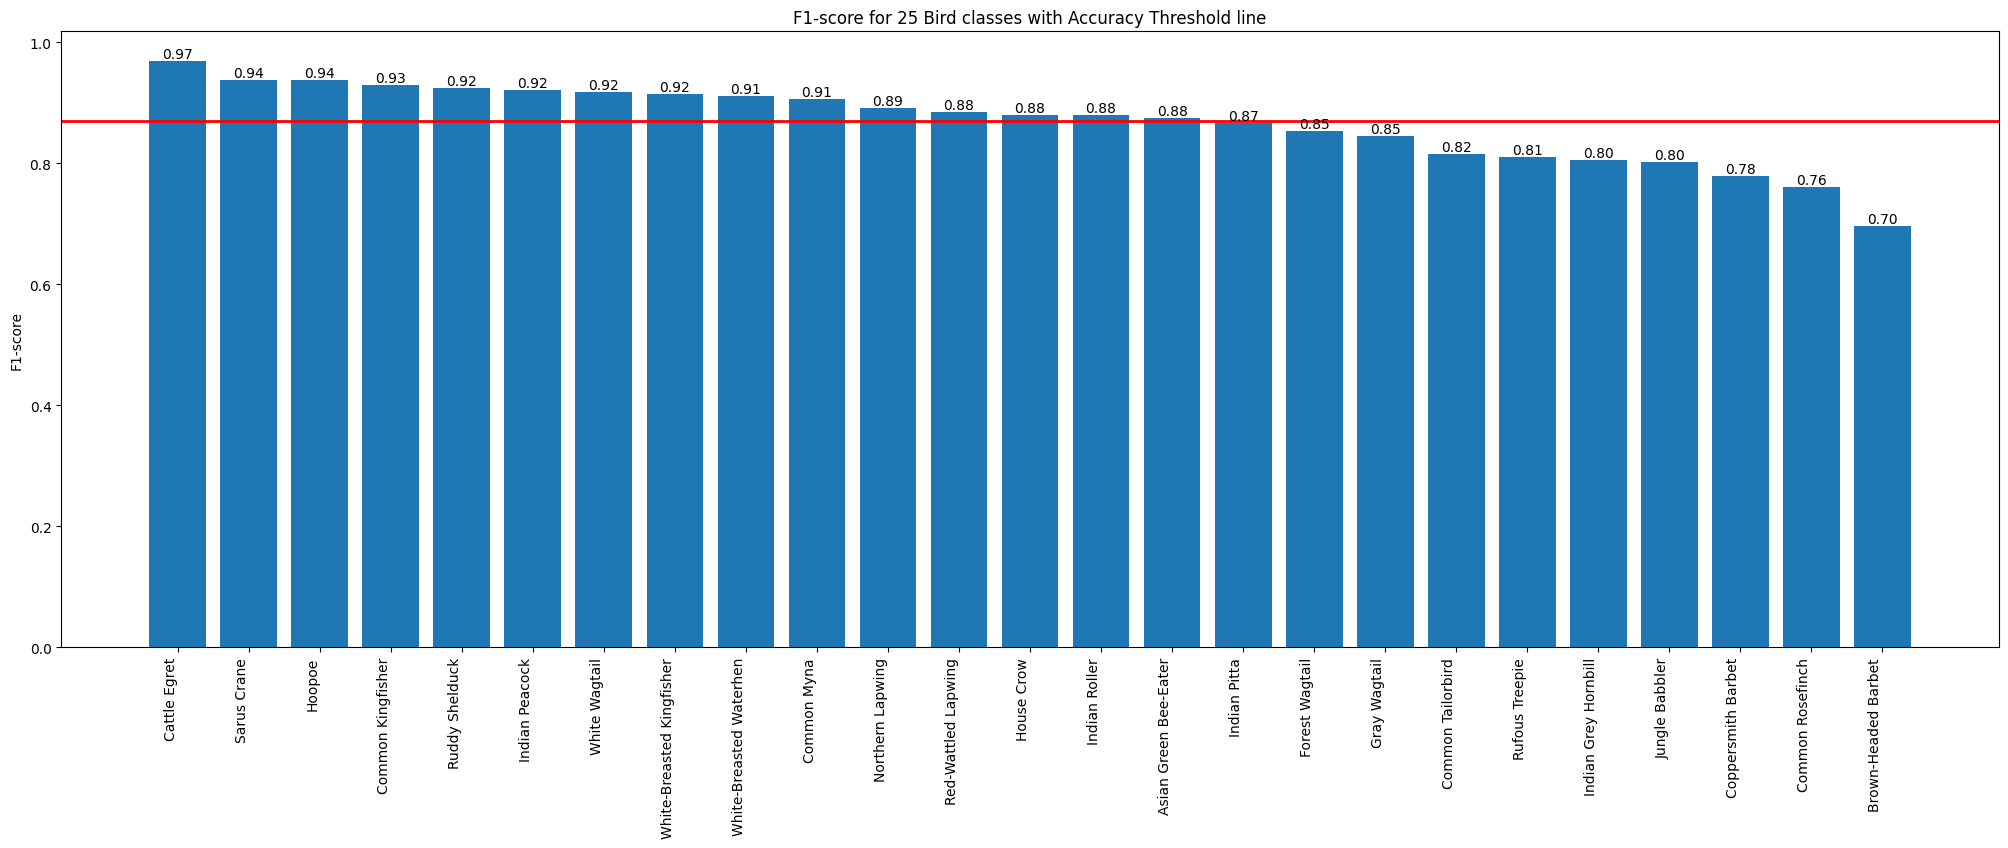

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(25, 8))
scores = ax.bar(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_xticks(range(len(f1_scores)))
ax.set_xticklabels(f1_scores["class_names"], rotation=90, ha='right')
ax.set_ylabel("F1-score")
plt.axhline(y=accuracy, linewidth=2, color='r')

ax.set_title("F1-score for 25 Bird classes with Accuracy Threshold line")
ax.bar_label(scores, fmt="%.2f");

## Visualizing predictions on test images

Steps:
* Read in a target inmage filepath using tf.io.read_file()
* turn the image into a tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1

In [62]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_size=224, scale=True):
    """
    reads in an image form filename, turns it into a tensor and reshapes into specified shape
    
    Args:
        filename (str): path to target image
        img_shape (int): height/width dimentions of target image size
        scale (bool): scale pixel values from 0-255 to  0-1 or not
        
    Returns:
        Image tensor of shape (img_shape, img_shape, 3)
    """
    # Read in the image
    img = tf.io.read_file(filename=filename)
    
    # Decode image into tensor
    img = tf.io.decode_image(img, channels=3)
    
    # Resize the image
    img = tf.image.resize(img, [img_size, img_size])
    
    # Scaling
    if scale:
        # Rescale the image
        return img/255.
    else:
        return img

1/1 [==============================] - 0s 30ms/step


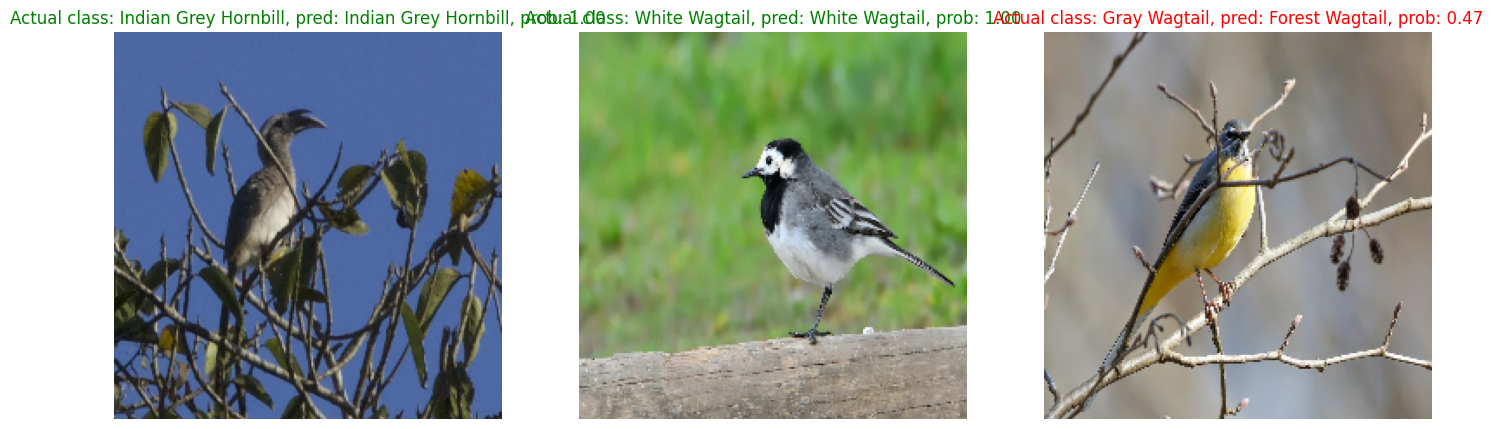

In [63]:
# visualize test images

# Make preds on series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
    # Choose a random image from random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + "/" + class_name + "/" + filename
    
    # Load the images and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    # pred_prob = model.predict(img_expanded) # get perdiction probability array
    pred_prob = model.predict(img_expanded) # get perdiction probability array
    pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index
    
    # Plot the images
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255)
    if class_name == pred_class: # if predicted class matches, truth class, make text green
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"Actual class: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);    

## Finding the most wrong predictions

In [64]:
# get all of the files from test_data
filepaths = []
for filepath in test_data.list_files("testing_set/*/*.jpg", shuffle=False):
    filepaths.append(filepath.numpy())
    
filepaths[:10]

[b'testing_set/Asian Green Bee-Eater/ML100845971.jpg',
 b'testing_set/Asian Green Bee-Eater/ML102065651.jpg',
 b'testing_set/Asian Green Bee-Eater/ML108389751.jpg',
 b'testing_set/Asian Green Bee-Eater/ML108490471.jpg',
 b'testing_set/Asian Green Bee-Eater/ML109116691.jpg',
 b'testing_set/Asian Green Bee-Eater/ML112055301.jpg',
 b'testing_set/Asian Green Bee-Eater/ML118156651.jpg',
 b'testing_set/Asian Green Bee-Eater/ML118645851.jpg',
 b'testing_set/Asian Green Bee-Eater/ML119513941.jpg',
 b'testing_set/Asian Green Bee-Eater/ML120026161.jpg']

In [65]:
# Create a dataframe of different parameters
pred_df = pd.DataFrame({"img_path": filepaths,
                       "y_true": y_label,
                       "y_pred": prediction,
                       "pred_conf": preds_probs.max(axis=1), # Get the maximum prediction probability value
                       "y_true_classname": [class_names[i] for i in y_label],
                       "y_pred_classname": [class_names[i] for i in prediction]})
pred_df

img_path  y_true  y_pred  \
0     b'testing_set/Asian Green Bee-Eater/ML10084597...       0       0   
1     b'testing_set/Asian Green Bee-Eater/ML10206565...       0       0   
2     b'testing_set/Asian Green Bee-Eater/ML10838975...       0      12   
3     b'testing_set/Asian Green Bee-Eater/ML10849047...       0       0   
4     b'testing_set/Asian Green Bee-Eater/ML10911669...       0       0   
...                                                 ...     ...     ...   
4509  b'testing_set/White-Breasted Waterhen/ML862254...      24      24   
4510  b'testing_set/White-Breasted Waterhen/ML870705...      24      24   
4511  b'testing_set/White-Breasted Waterhen/ML872301...      24      24   
4512  b'testing_set/White-Breasted Waterhen/ML912482...      24      24   
4513  b'testing_set/White-Breasted Waterhen/ML923868...      24      24   

      pred_conf         y_true_classname         y_pred_classname  
0      0.966927    Asian Green Bee-Eater    Asian Green Bee-Eater  
1      0.999225    Asian Green Bee-Eater    Asian Green Bee-Eater  
2      0.334575    Asian Green Bee-Eater     Indian Grey Hornbill  
3      0.999982    Asian Green Bee-Eater    Asian Green Bee-Eater  
4      0.958633    Asian Green Bee-Eater    Asian Green Bee-Eater  
...         ...                      ...                      ...  
4509   0.725891  White-Breasted Waterhen  White-Breasted Waterhen  
4510   0.999892  White-Breasted Waterhen  White-Breasted Waterhen  
4511   0.999891  White-Breasted Waterhen  White-Breasted Waterhen  
4512   0.970743  White-Breasted Waterhen  White-Breasted Waterhen  
4513   0.999579  White-Breasted Waterhen  White-Breasted Waterhen  

[4514 rows x 6 columns]

In [66]:
# Find which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'testing_set/Asian Green Bee-Eater/ML10084597...       0       0   
1  b'testing_set/Asian Green Bee-Eater/ML10206565...       0       0   
2  b'testing_set/Asian Green Bee-Eater/ML10838975...       0      12   
3  b'testing_set/Asian Green Bee-Eater/ML10849047...       0       0   
4  b'testing_set/Asian Green Bee-Eater/ML10911669...       0       0   

   pred_conf       y_true_classname       y_pred_classname  pred_correct  
0   0.966927  Asian Green Bee-Eater  Asian Green Bee-Eater          True  
1   0.999225  Asian Green Bee-Eater  Asian Green Bee-Eater          True  
2   0.334575  Asian Green Bee-Eater   Indian Grey Hornbill         False  
3   0.999982  Asian Green Bee-Eater  Asian Green Bee-Eater          True  
4   0.958633  Asian Green Bee-Eater  Asian Green Bee-Eater          True

In [67]:
# Sort dataframe to have most wrong predictions at top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
191   b'testing_set/Brown-Headed Barbet/ML119679471....       1       7   
2099          b'testing_set/House Crow/ML256308541.jpg'      11       4   
1135   b'testing_set/Common Tailorbird/ML149453221.jpg'       6       9   
2331  b'testing_set/Indian Grey Hornbill/ML63915191....      12       8   
565    b'testing_set/Common Kingfisher/ML152225741.jpg'       3      23   
231   b'testing_set/Brown-Headed Barbet/ML196420071....       1      16   
2917      b'testing_set/Jungle Babbler/ML282513391.jpg'      16       6   
4169  b'testing_set/White-Breasted Kingfisher/ML1646...      23      18   
806          b'testing_set/Common Myna/ML221310241.jpg'       4      24   
1338  b'testing_set/Coppersmith Barbet/ML176468941.jpg'       7      11   
1306  b'testing_set/Coppersmith Barbet/ML131700641.jpg'       7      14   
3887         b'testing_set/Sarus Crane/ML350856521.jpg'      21       2   
4109       b'testing_set/White Wagtail/ML498687651.jpg'      22       8   
361   b'testing_set/Brown-Headed Barbet/ML91802381.jpg'       1       5   
1279    b'testing_set/Common Tailorbird/ML81698581.jpg'       6      16   
1492      b'testing_set/Forest Wagtail/ML212905501.jpg'       8       9   
2683       b'testing_set/Indian Roller/ML120308811.jpg'      15       5   
4469  b'testing_set/White-Breasted Waterhen/ML351459...      24      20   
1331  b'testing_set/Coppersmith Barbet/ML155867261.jpg'       7      20   
1190   b'testing_set/Common Tailorbird/ML205140771.jpg'       6       9   

      pred_conf           y_true_classname           y_pred_classname  \
191    0.999370        Brown-Headed Barbet         Coppersmith Barbet   
2099   0.999160                 House Crow                Common Myna   
1135   0.998646          Common Tailorbird               Gray Wagtail   
2331   0.998476       Indian Grey Hornbill             Forest Wagtail   
565    0.998271          Common Kingfisher  White-Breasted Kingfisher   
231    0.996154        Brown-Headed Barbet             Jungle Babbler   
2917   0.995713             Jungle Babbler          Common Tailorbird   
4169   0.995000  White-Breasted Kingfisher        Red-Wattled Lapwing   
806    0.994229                Common Myna    White-Breasted Waterhen   
1338   0.993855         Coppersmith Barbet                 House Crow   
1306   0.993511         Coppersmith Barbet               Indian Pitta   
3887   0.990375                Sarus Crane               Cattle Egret   
4109   0.990031              White Wagtail             Forest Wagtail   
361    0.988294        Brown-Headed Barbet           Common Rosefinch   
1279   0.984620          Common Tailorbird             Jungle Babbler   
1492   0.983442             Forest Wagtail               Gray Wagtail   
2683   0.980947              Indian Roller           Common Rosefinch   
4469   0.979722    White-Breasted Waterhen             Rufous Treepie   
1331   0.979433         Coppersmith Barbet             Rufous Treepie   
1190   0.975412          Common Tailorbird               Gray Wagtail   

      pred_correct  
191          False  
2099         False  
1135         False  
2331         False  
565          False  
231          False  
2917         False  
4169         False  
806          False  
1338         False  
1306         False  
3887         False  
4109         False  
361          False  
1279         False  
1492         False  
2683         False  
4469         False  
1331         False  
1190         False

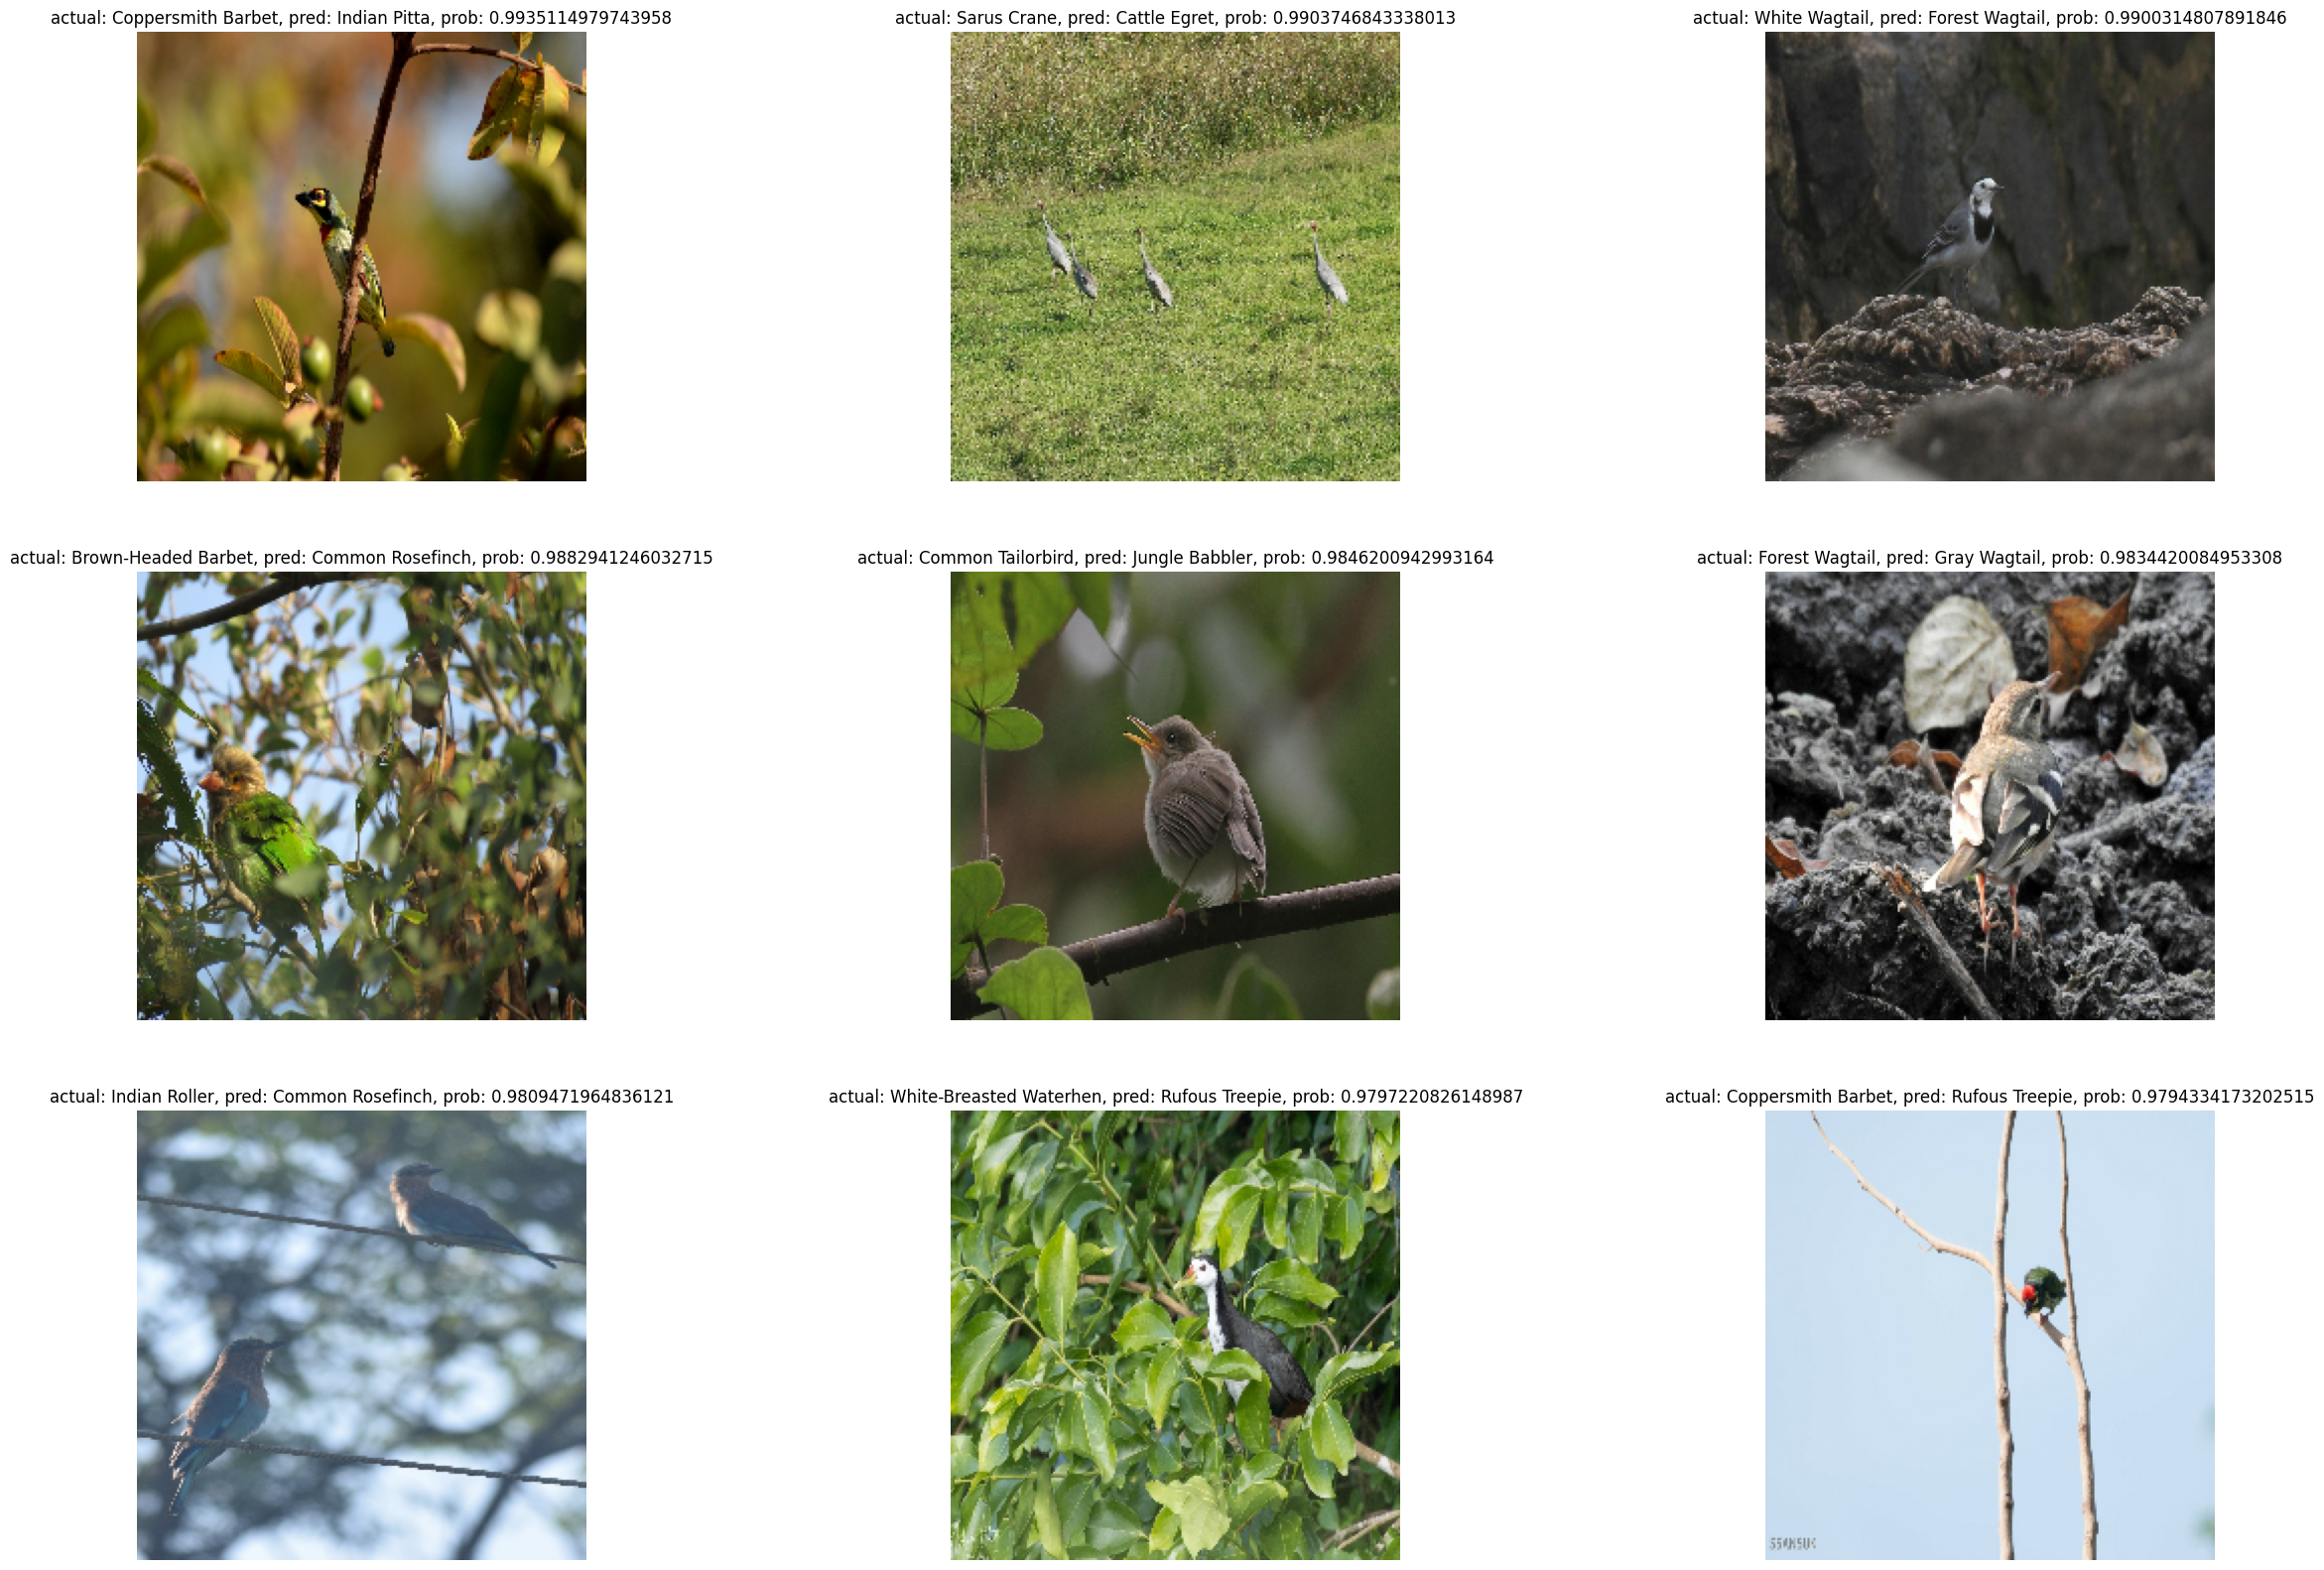

In [68]:
# Visualize wrong predictions
images_to_view = 9
start_index = 10
plt.figure(figsize=(30, 20))
for i, row in enumerate(top_100_wrong[start_index:start_index + images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row[1], scale=False)
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # skipping few values
    plt.imshow(img/255)
    plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}, prob: {pred_prob}")
    plt.axis(False);

## Testing on Custom Images

In [74]:
custom_bird_images = ["custom_images/" + img_path for img_path in os.listdir("custom_images")]

In [75]:
custom_bird_images

['custom_images/hoopoe.jpg',
 'custom_images/Indian Pitta.jpg',
 'custom_images/crow.jpg',
 'custom_images/Common tailorbird Orthotomus sutorius.jpg',
 'custom_images/Common myna.jpg']

1/1 [==============================] - 0s 26ms/step


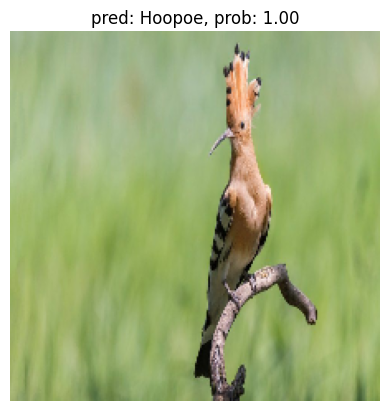

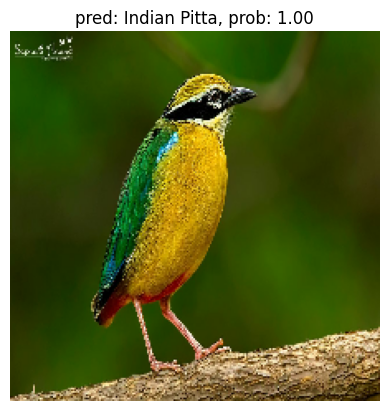

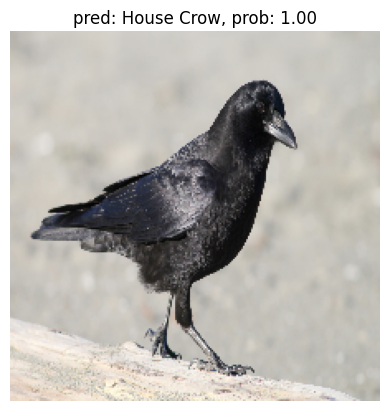

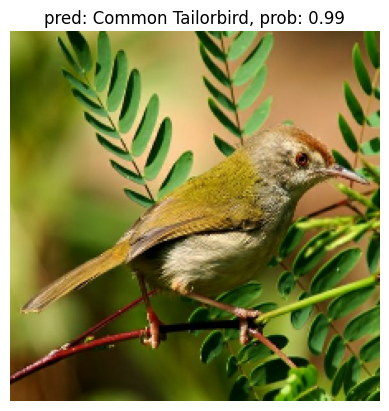

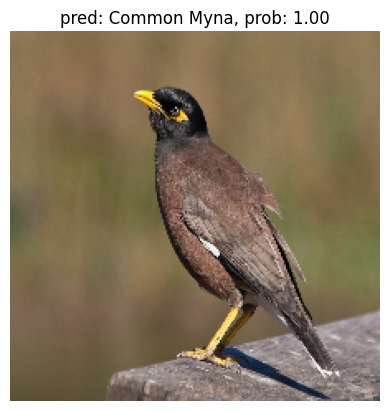

In [76]:
# make predictions and plot custom food images
for img in custom_bird_images:
    img = load_and_prep_image(img, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]
    
    # Plot the information
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis(False);

### Using TensorBoard for better visualizations

In [128]:
%load_ext tensorboard

In [137]:
!tensorboard dev auth revoke

2023-03-28 16:08:21.014981: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-28 16:08:22.259226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 16:08:22.312230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 16:08:22.312308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
Logged out of uploader.


In [ ]:
!tensorboard dev upload --one_shot --logdir transfer_learning/

2023-03-28 16:08:26.376638: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-28 16:08:27.540871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 16:08:27.589219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 16:08:27.589297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.

***** TensorBoard Uploader ***

TensorBoard Experiment: https://tensorboard.dev/experiment/dX0p7nQQRPGpFxozjjaZkw/#scalars&runSelectionState=eyJiYXNlX21vZGVsLzIwMjMwMzI1LTE5NDEwNC90cmFpbiI6ZmFsc2V9&run=base_model%2F20230325-193754%2Ftrain

## Conclusion

- After fine-tuning, we are seeing somewhat improved accuracy than base model. However, as per trend, we can see that with much longer training, it will be able to improve accuracy to much heigher level. 
- Next step would be to implement siamese network to add more classes to our classification model.
- Idea is to implement siamese network using this dataset: https://www.kaggle.com/datasets/gpiosenka/100-bird-species 
- This will add 510 classes to the model